In [1]:
from turtle import distance
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import config.config as config
from scipy import spatial
import time
from sklearn.metrics.pairwise import cosine_similarity

In [39]:
pc = pd.read_csv('../data/sample_id_0__curve__rain_rate_0__pc.csv')
data = pd.read_csv('../data/sample_id_0__curve__rain_rate_0__lidar__data.csv')
pc_array = np.stack([pc['pc_x'], pc['pc_y'], pc['reflect']], axis=1)
positions = np.stack([data['positions_x_ground_truth'], data['positions_y_ground_truth']], axis=1)

In [59]:
def apply_rain(position, rain_rate): 
    p_min = 0.9/(np.pi * config.lidar_range**2)
    # get all points in range of lidar sensor
    subs = (position - pc_array[:,0:2])
    # calculate their range
    ranges = np.linalg.norm(subs, axis=1)
    angles = np.arctan2(subs[:,1], subs[:,0])
    print(ranges.shape, angles.shape)

    ranges_in_range = ranges[ranges < config.lidar_range]
    angles_in_range = angles[ranges < config.lidar_range]
    print(ranges_in_range.shape, angles_in_range.shape)
    
    reflectivities = pc_array[:,2][ranges < config.lidar_range]
    new_intensities = reflectivities/(ranges_in_range**2) * np.exp(-0.02*(rain_rate**0.6)*ranges_in_range)
    taken_ranges = ranges_in_range[new_intensities > p_min]
    taken_angles = angles_in_range[new_intensities > p_min]
    if (len(taken_ranges[taken_ranges < 0]) > 0): 
        taken_ranges[taken_ranges < 0] = 0
        
    taken_intensities = new_intensities[new_intensities > p_min]
    noisy_ranges = np.random.normal(0, 0.02*taken_ranges*(1-np.exp(-rain_rate))**2)

    return subs, taken_ranges, taken_angles

(798,) (798,)
(437,) (437,)


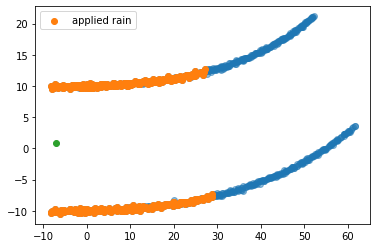

In [74]:
subs, ranges, angles = apply_rain(positions[50], 0)
subs_from_polar = np.stack([ranges * np.cos(angles), ranges * np.sin(angles)], axis=1)
plt.scatter(subs[:,0], subs[:,1], alpha = 0.5)
plt.scatter(subs_from_polar[:,0], subs_from_polar[:,1], label="applied rain")
plt.scatter(positions[50][0], positions[50][1])
plt.legend()


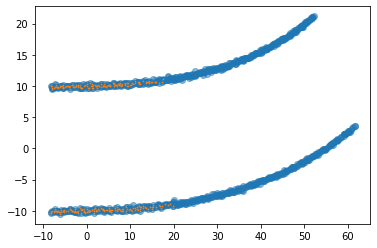

In [79]:
from queue import SimpleQueue
from statistics import median


def get_pc_similarity(starting_pos,position, position_2): 
   
    # get all points in range of lidar sensor
    subs = (position - pc_array[:,0:2])
    # calculate their range
    ranges = np.linalg.norm(subs, axis=1)
    in_range = np.array(subs[ranges<config.lidar_range])

    subs_2 = (position_2 - pc_array[:,0:2])
    # calculate their range
    ranges_2 = np.linalg.norm(subs_2, axis=1)
    in_range_2 = np.array(subs_2[ranges_2<config.lidar_range])
    
    distance_to_zero = spatial.distance.directed_hausdorff(np., in_range)[0]
    distance_to_zero_2 = spatial.distance.directed_hausdorff(in_range_start, in_range_2)[0]
    #print(distance_to_zero, distance_to_zero_2)
    return stats.norm(distance_to_zero, .2).pdf(distance_to_zero_2)
    #likelihoods = stats.norm(mode, config.lidar_sensor_std).pdf(mode_2)
    #likelihoods = stats.norm(mean, config.lidar_sensor_std).pdf(mean_2)
    
    


In [80]:
init_pos_index = 0
other_indicies = np.arange(init_pos_index, 399, 20)
for oi in other_indicies: 
    print(init_pos_index, " - ", oi, ": ", (get_pc_similarity(positions[0],positions[init_pos_index], positions[oi])))


ValueError: u and v need to have the same number of columns

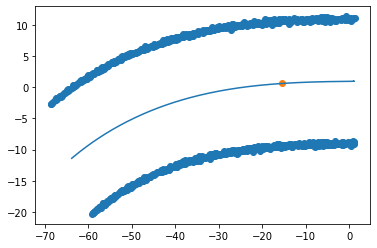

In [19]:
plt.plot(data['positions_x_ground_truth'], data['positions_y_ground_truth'])
plt.scatter(pc_array[:,0],pc_array[:,1])
plt.scatter(positions[100][0], positions[100][1])

In [56]:
spatial.distance.directed_hausdorff(one, two)

IndexError: tuple index out of range